# GSoC evaluation exercise for ATLAS project
### Elaborated by: Antonio Alvarez

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets, models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from sklearn.preprocessing import scale
import pickle

The next two classes represent the Autoencoder. Under the principle KIS (Keep It Simple), this is an undercomplete autoencoder, this means that the number of dimensions of the hidden layer is less than the number in the input layer, forcing the network to learn the most prominent features to compress the data (in this case, from 4D to 3D). 

Additionally, the whole network only has 3 layers: an input layer, a single hidden layer that produces the encoded data, and an output layer that reconstructs a 4D instance from a 3D compression. A simple undercomplete structure with few layers omits the need of regularization techniques to avoid overfitting (i.e., the network will generalize well to new data), and the computation time is shortened considerably.

The activation function used in the hidden layer is [relu](http://proceedings.mlr.press/v15/glorot11a/glorot11a.pdf): $F(x) = max(0,x)$. This function gives the autoencoder the possibility to find a **non-linear** subspace that minimizes the reconstruction error, which is more powerful than [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) (in fact, if the activation function of the hidden layer were just the identity function, the autoencoder would behave like PCA). 

In [2]:
class Encoder(nn.Module):
    """ Encoder that reduces an input from 4 dimensions to 3"""
    
    def __init__(self):
        super(Encoder,self).__init__()
        self.fc = nn.Linear(4,3)
        
    def forward(self,input):
        return F.relu(self.fc(input))

In [3]:
class Decoder(nn.Module):
    """ Decoder that reconstructs a 4-dimensional vector from a 3-dimensional input """
    
    def __init__(self):
        super(Decoder,self).__init__()
        self.fc = nn.Linear(3,4)
        
    def forward(self,input):
        return self.fc(input)

In [4]:
def train(encoder,decoder,loader,enc_optimizer,dec_optimizer,criterion,epochs,device):
    """Trains the given model
    
    Args:
        encoder (nn.Module inherited class) : encoder used
        decoder (nn.Module inherited class) : decoder used
        loader (data.DataLoader) : loader used for training 
        enc_optimizer (optim): encoder optimizer
        dec_optimizer (optim): decoder optimizer
        criterion (torch.nn criterion): criterion used for the optimization
        epochs (int): # epochs for training 
        device (torch.device) : device where the computation will take place 
    """
    epoch_values = [] 
    for j in range(epochs):

        running_loss = 0.0
        loss_values = 0
        num_batches = 0
        
        for i, data in enumerate(loader, 0):
    
            inputs = data.to(device)
            
            #We clean the gradients
            enc_optimizer.zero_grad()
            dec_optimizer.zero_grad()
            
            compressed = encoder(inputs) #Encode
            outputs = decoder(compressed) #Decode
            
            loss = criterion(outputs,inputs) #calculate loss
            loss.backward() #backpropagate
            
            #Update weights 
            enc_optimizer.step() 
            dec_optimizer.step()

            running_loss += loss.item()
            loss_values += loss.item()
            num_batches += 1
            if i % 5000 == 4999:
                print('[%d, %5d] loss: %.3f' %
                          (j + 1, i + 1, running_loss / 5000))
                running_loss = 0.0
                
        epoch_values.append(loss_values / num_batches)
                
    print("Finished training") 
    fig, ax = plt.subplots()
    ax.plot(np.array(epoch_values), 'r')
    ax.set(xlabel='Number of epochs', ylabel='MSE',title='Training Error')
    plt.savefig('training_error.png')
    plt.show()

In [5]:
def testing(encoder,decoder,loader,device,remove_outliers=False):
    
    """Tests the given model
    
   Args:
        encoder (nn.Module inherited class) : encoder used
        decoder (nn.Module inherited class) : decoder used
        loader (data.DataLoader) : loader used for testing
        device (torch.device) : device where the computation will take place
        remove_outliers (Bool): flag that determines if the outliers will be removed from the plots 
                                (True) or not (False)
    """

    error_list = []           
    with torch.no_grad():
        for data in loader:
            inputs = data.to(device)
            compressed = encoder(inputs) #Encodes 
            outputs = decoder(compressed) # Decodes
            #Calculate the difference between original and reconstructed instances
            batch_error = inputs - outputs / inputs 
            error_list.append(batch_error)

    attributes = ["m","pt","phi","eta"]
    error = torch.cat(error_list,0).numpy()
    if remove_outliers:
        error = error[~is_outlier(error)] #Removes outliers
    instances = range(error.shape[0])
    var_index = 0
    str_outlier = "_without_outliers" if remove_outliers else ""
    
    for i in range(4):
        fig, ax = plt.subplots()
        ax.scatter(instances,error[:,var_index])
        ax.set(xlabel='Instances', ylabel='original - uncompressed / original', 
                         title='Variable ' + attributes[var_index])
        plt.savefig('error_' + attributes[var_index] + str_outlier + '.png')
        plt.show()
        var_index += 1

The function below was taken from [stackoverflow](https://stackoverflow.com/questions/11882393/matplotlib-disregard-outliers-when-plotting). It identifies outliers based on  median absolute deviation. This will be necessary to better appreciate the dispersion of the data.

In [6]:
# Taken from : https://stackoverflow.com/questions/11882393/matplotlib-disregard-outliers-when-plotting
# Credits: Joe Kington

def is_outlier(points, thresh=50):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

## Main Module

First, we select the device to work on, prioritizing GPU if it is available 

In [7]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

Next, we load and pre-process the data. Reading each line from inside out:

1. First we load the pickle data with **pickle.load**, this gives us a pandas dataframe.
2. Then we fill possible missing values with 0, using **fillna**, so we can work focusing only with numeric data (they could be filled with other values, given a more thorough knowledge of the dataset).
3. The next step is scaling the data with **scale**, centering to the mean and with unit variance. **Scale** also transforms the pandas dataframe into a numpy array. 
4. Finally, we convert to a float tensor with **torch.from_numpy**. Tensors will be the standard element to be processed by the networks 

In [8]:
train_set = torch.from_numpy(scale(pickle.load(open(
             "all_jets_train_4D_100_percent.pkl","rb")).fillna(0))).float()
test_set  = torch.from_numpy(scale(pickle.load(open(
             "all_jets_test_4D_100_percent.pkl","rb")).fillna(0))).float()

Below we define the loaders that will be iterated over to train and test the autoencoder. Set the criterion to [MSE](https://en.wikipedia.org/wiki/Mean_squared_error) as the difference estimator, or in the specific case of autoencoders, the reconstruction loss. Additionally, we set [Adam](https://arxiv.org/pdf/1412.6980.pdf) with default parameters as the optimizer for both the Encoder and Decoder. Adam is selected because it as proven to be effective with minimum parameter adjusting. 

In [9]:
trainloader = DataLoader(train_set, batch_size=5, shuffle=True)
testloader = DataLoader(test_set, batch_size=5, shuffle=True)
encoder = Encoder().to(device)
decoder = Decoder().to(device)
criterion = nn.MSELoss()
enc_optimizer = optim.Adam(encoder.parameters())
dec_optimizer = optim.Adam(decoder.parameters())

For this dataset, we don't need a lot of epochs to converge to a local minimum, so we set the number of epochs to 5 and train the model. At the end of the output we can see a plot for the training reconstruction loss.

[1,  5000] loss: 0.158
[1, 10000] loss: 0.032
[1, 15000] loss: 0.032
[1, 20000] loss: 0.033
[2,  5000] loss: 0.033
[2, 10000] loss: 0.032
[2, 15000] loss: 0.032
[2, 20000] loss: 0.032
[3,  5000] loss: 0.032
[3, 10000] loss: 0.032
[3, 15000] loss: 0.032
[3, 20000] loss: 0.032
[4,  5000] loss: 0.032
[4, 10000] loss: 0.032
[4, 15000] loss: 0.033
[4, 20000] loss: 0.032
[5,  5000] loss: 0.030
[5, 10000] loss: 0.033
[5, 15000] loss: 0.033
[5, 20000] loss: 0.032
Finished training


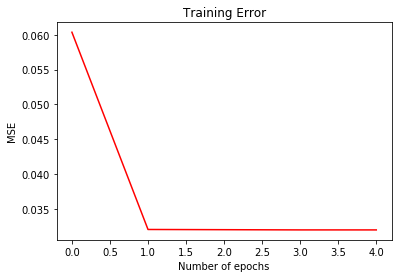

In [10]:
train(encoder,decoder,trainloader,enc_optimizer,dec_optimizer,criterion,5,device)

We plot as a scatterplot 
$$
\frac{original\_variable -  uncompressed\_variable}{original\_variable}
$$
each variable.

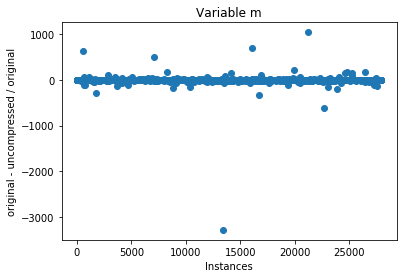

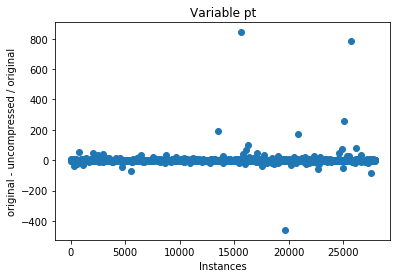

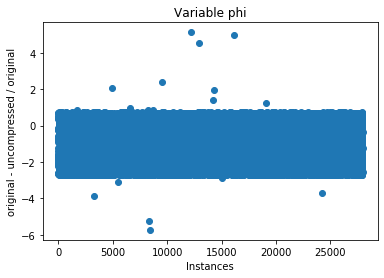

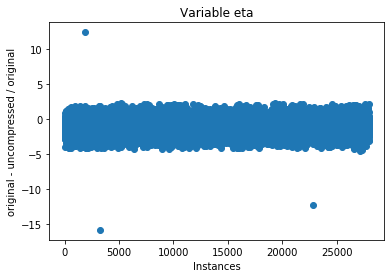

In [11]:
testing(encoder,decoder,testloader,device)

The above plots show that there are some notable outliers that distort the visualization of the difference between original and uncompressed data, specially for variables **m** and **pt**. Maybe these outliers are anomalies. For now we exclude them.

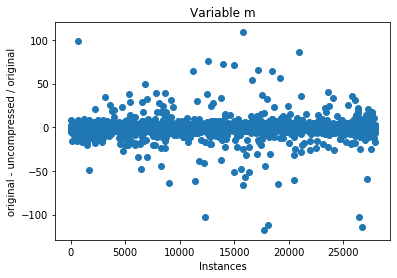

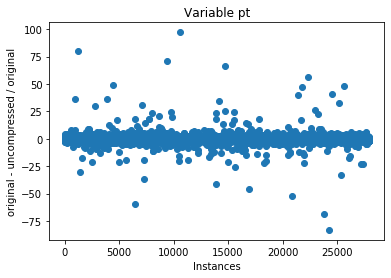

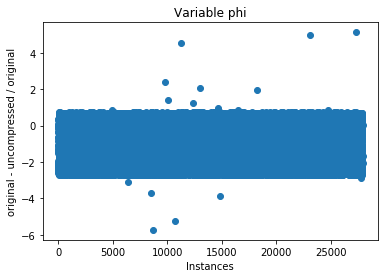

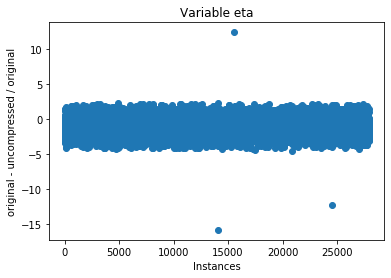

In [12]:
testing(encoder,decoder,testloader,device,True)

In the end we see that there is a considerable dispersion of the points for variables **m** and **pt**, while the points for variables **phi** and **eta** are more compacted around 0. This means that the autoencoder identified  **phi** and **eta** as the most prominent features and based the compression around these two attributes, losing some of the information from the other two variables. This selection of features could be of interest to physicists as it could give more information on the phenomena being studied.